In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline

#loop through each saved sample
spectro_list = []
for i in range(4210):
    #read in the .wav file and create a spectrogram array
    sample_rate, samples = wavfile.read(rf"C:\Users\william.niven\mono_wavs\sample_{i}.wav")
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    #take the log of these values and append to our list
    spectro_list.append(np.log(spectrogram))
#create a dataframe of these arrays    
spec_df = pd.DataFrame({"spectros":spectro_list})

C:\Users\william.niven\AppData\Local\Temp\ipykernel_4608\2371218122.py:14: RuntimeWarning: divide by zero encountered in log
  spectro_list.append(np.log(spectrogram))


In [2]:
final_df = pd.read_csv("final.csv")

In [3]:
#encode our boolean values as a 0 or 1 for the NN
final_df.boom_bust = final_df.boom_bust.map({True: 1, False: 0})

In [4]:
count = 0
my_X = []
my_y = []
#filter for sample that have 5849 samplings
#this is because all inputs to a CNN must be the same size
for i in range(len(spec_df.spectros)):
    if spec_df.spectros[i].shape == (129,5849):
        my_X.append(spec_df.spectros[i])
        my_y.append(final_df.boom_bust[i])
print(f"X len = {len(my_X)} and y len = {len(my_y)}")
my_X = np.array(my_X)
my_y = np.array(my_y)

X len = 4196 and y len = 4196


In [5]:
# Get rid of negative infinity values and other super small values
my_X[my_X < -40] = -40

In [8]:
#normalize the spectrogram data
normal_X = (my_X - my_X.min()) / (my_X.max() - my_X.min())

In [10]:
#create an extra dimension for CNN
#our input only has 1 channel (decibels)
normal_X = normal_X.reshape((4196,129,5849,1))

In [11]:
#add dimension to outcome vector
my_y = my_y.reshape((4196,1))

In [12]:
#80/20 split for training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(normal_X, my_y,test_size = 0.2, random_state = 42)

In [15]:
#create our model with 5 convolutional layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (4,4), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (4,4), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (4,4), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (4,4), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (4,4), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#compile
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

#fit
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5155 - loss: 0.6947 - val_accuracy: 0.5095 - val_loss: 0.6940
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 881ms/step - accuracy: 0.5256 - loss: 0.6924 - val_accuracy: 0.5095 - val_loss: 0.6950
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 885ms/step - accuracy: 0.5487 - loss: 0.6888 - val_accuracy: 0.5095 - val_loss: 0.6930
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 94s 894ms/step - accuracy: 0.5374 - loss: 0.6913 - val_accuracy: 0.5095 - val_loss: 0.6936
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 877ms/step - accuracy: 0.5376 - loss: 0.6909 - val_accuracy: 0.5095 - val_loss: 0.6943
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 883ms/step - accuracy: 0.5302 - loss: 0.6920 - val_accuracy: 0.5095 - val_loss: 0.6938
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 888ms/step - accuracy: 0.5379 - loss: 0.6906 - val_accuracy: 0.5095 - val_loss: 0.6934
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 879ms/step - accuracy: 0.5481 - loss: 0.6

<Axes: >

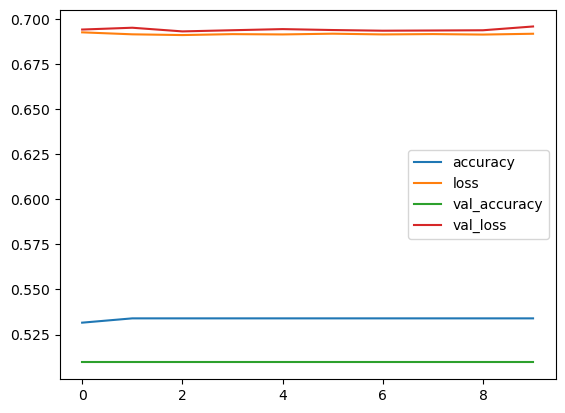

In [16]:
#plot performance
pd.DataFrame(history.history).plot()

In [17]:
#write these outcomes to a csv
pd.DataFrame(history.history).to_csv("second_try.csv")

In [16]:
np.array(np.unique(y_valid, return_counts=True)).T

array([[  0, 428],
       [  1, 412]], dtype=int64)

In [20]:
#dummy classifier
428 / (428+412)

0.5095238095238095